In [1]:
from split_data import split
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [3]:
source_path = "../Data/Original/Apple"
training_path = "../train_data/"
testing_path = "../test_data/"
train_test_ratio = 0.7
split(source_path, training_path, testing_path, train_test_ratio) 

Finish splitting Apple_scab
[Training Samples:441, Testing Samples:189]   Original Samples:630
---------------------
Finish splitting Healthy
[Training Samples:1151, Testing Samples:494]   Original Samples:1645
---------------------
Finish splitting Cedar_apple_rust
[Training Samples:192, Testing Samples:83]   Original Samples:275
---------------------
Finish splitting Black_rot
[Training Samples:435, Testing Samples:186]   Original Samples:621
---------------------
Total Training Samples: 2219, Testing Samples: 952, Total Samples: 3171


In [4]:
# train_dataset = ImageFolder(training_path, transform = transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor()
# ]))

# test_dataset = ImageFolder(testing_path,transforms.Compose([
#     transforms.Resize((150,150)),transforms.ToTensor()
# ]))


# ---------------------------[no resize]-------------------------------------


train_dataset = ImageFolder(training_path, transform = transforms.Compose([
    transforms.ToTensor()
]))

test_dataset = ImageFolder(testing_path,transforms.Compose([
    transforms.ToTensor()
]))
classes = train_dataset.classes

torch.Size([3, 256, 256])


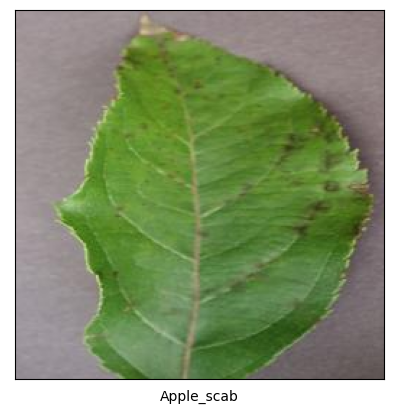

In [5]:
def display_img(img,label):
    plt.imshow(img.permute(1,2,0))
    plt.xlabel(classes[label])
    plt.xticks([])
    plt.yticks([])
    

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=10).permute(1,2,0))
        break

def show_batch_with_labels(dl):
    plt.figure(figsize=(10,10))
    images, labels = next(iter(dl))
    for i in range(25):
        plt.subplot(5,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        display_img(images[i],labels[i].item())
    plt.show()

#display the first image in the dataset
display_img(*train_dataset[0])

print((train_dataset[0][0].size()))

In [15]:
batch_size = 4
train_val_ratio = 0.8
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data,val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

Length of Train Data : 1775
Length of Validation Data : 444


In [7]:
len(train_dl)

444

In [8]:
# Show first 25 images in the first batvh
# show_batch_with_labels(train_dl)

# dataiter = iter(train_dl)
# images, label = next(dataiter)
# # display_img(images, label)
# conv11 = nn.Conv2d(3,6,5)
# pooll = nn.MaxPool2d(5,5)
# conv22 = nn.Conv2d(6, 16, 5)

In [9]:
# (w - F + 2P)/S + 1


# print(images.shape)
# x = conv11(images)
# print(x.shape)
# x = pooll(x)
# print(x.shape)
# x = conv22(x)
# print(x.shape)
# x = pooll(x)
# print(x.shape)



### BASE CNN

In [10]:
class Net(nn.Module):
    
    def __init__(self):
        """Initialise a base network"""
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.maxpool = nn.MaxPool2d(5, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        
        self.fc1 = nn.Linear(16*9*9, 120)  #Dimension after convolution and pooling 
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 4)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))

        x = x.view(-1, 16*9*9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [12]:
num_epochs = 10
lr = 0.1
model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(i)
        running_loss += loss.item()
        if (i+1) % 444 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


[1,   444] loss: 0.262
[2,   444] loss: 0.226
[3,   444] loss: 0.192
[4,   444] loss: 0.192
[5,   444] loss: 0.174
[6,   444] loss: 0.194
[7,   444] loss: 0.158
[8,   444] loss: 0.134
[9,   444] loss: 0.132
[10,   444] loss: 0.143


In [25]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_classcorrect = [0 for i in range(4)] 
    n_classsamples = [0 for i in range(4)]

    for images, labels in val_dl:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)

        _, predicted = torch.max(output, 1)
        n_samples += labels.size(0)
        n_correct += (predicted==labels).sum().item()


        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_classcorrect[label] += 1
            n_classsamples[label] += 1
        
    acc = (n_correct/n_samples)*100
    print(f"samples accuracy: {acc:.3f}%")

    for i in range(4):
        acc = n_classcorrect[i]/n_classsamples[i] *100
        print(f"Acc for Class {classes[i]} = {acc:.3f}%")


samples accuracy: 51.802%
Acc for Class Apple_scab = 2.105%
Acc for Class Black_rot = 22.826%
Acc for Class Cedar_apple_rust = 0.000%
Acc for Class Healthy = 98.571%
